In [25]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import seaborn as sns
from tqdm.notebook import tqdm
# Imports
from scipy.signal import resample
import pywt
import heartpy as hp
from scipy.signal import savgol_filter
from scipy.signal import butter, filtfilt, resample
from scipy import signal
from data_subplot import data_subplot
from scipy.stats import pearsonr
from detect_body_movements import detect_patterns
from band_pass_filtering import band_pass_filtering
from modwt_matlab_fft import modwt
from modwt_mra_matlab_fft import modwtmra
import math
from remove_nonLinear_trend import remove_nonLinear_trend
from compute_vitals import vitals
dataset_folder = r"C:\Users\tony_\OneDrive\Desktop\data analytics\project\dataset\dataset\data"

In [20]:
!pip install PyWavelets


   ---------------------------------------- 0.0/4.2 MB ? eta -:--:--
   ---- ----------------------------------- 0.5/4.2 MB 3.3 MB/s eta 0:00:02
   --------- ------------------------------ 1.0/4.2 MB 3.1 MB/s eta 0:00:02
   ----------------- ---------------------- 1.8/4.2 MB 3.6 MB/s eta 0:00:01
   --------------------------- ------------ 2.9/4.2 MB 3.6 MB/s eta 0:00:01
   ---------------------------------- ----- 3.7/4.2 MB 3.7 MB/s eta 0:00:01
   ---------------------------------------- 4.2/4.2 MB 3.7 MB/s eta 0:00:00


In [24]:
!pip install heartpy
!pip install pyfftw

   ---------------------------------------- 0.0/2.6 MB ? eta -:--:--
   --- ------------------------------------ 0.3/2.6 MB ? eta -:--:--
   --------------- ------------------------ 1.0/2.6 MB 3.9 MB/s eta 0:00:01
   --------------------------- ------------ 1.8/2.6 MB 3.7 MB/s eta 0:00:01
   ---------------------------------------- 2.6/2.6 MB 3.6 MB/s eta 0:00:00


## 1. File Loading Functions

In [2]:
def load_bcg_with_timestamps(file_path):
    """Load BCG data and generate timestamps for all samples"""
    try:
        # Read CSV file
        df = pd.read_csv(file_path)

        # Extract metadata from first row
        initial_timestamp = df.at[0, 'Timestamp']
        fs = df.at[0, 'fs']  # Sampling frequency in Hz
        sample_interval = (1/fs) * 1000  # Milliseconds per sample

        # Generate timestamps for all samples
        timestamps = [initial_timestamp + i*sample_interval
                      for i in range(len(df))]

        # Add timestamps and clean dataframe
        df['Timestamp'] = timestamps
        df['Datetime'] = pd.to_datetime(df['Timestamp'], unit='ms')

        return df

    except Exception as e:
        print(f"Error processing {file_path}: {str(e)}")
        return None

# %%


def load_reference_rr_data(file_path):
    """Robust RR timestamp parser with multiple fallback options"""
    try:
        # Read CSV with stricter parsing
        df = pd.read_csv(file_path, engine='python')

        # Clean column names (strip whitespace)
        df.columns = df.columns.str.strip()

        # Check for required columns
        required_cols = ['Timestamp', 'RR Interval in seconds']
        if not all(col in df.columns for col in required_cols):
            print(f"Missing required columns in {file_path}")
            return None

        # Pre-clean timestamps
        df['Timestamp'] = df['Timestamp'].astype(str).str.strip()

        # Try multiple parsing methods
        parsed_successfully = False

        # Method 1: Direct parsing with expected format
        df['Datetime'] = pd.to_datetime(
            df['Timestamp'],
            format='%d-%m-%y %H:%M',
            errors='coerce'
        )

        # Method 2: Try with different delimiters if first fails
        if df['Datetime'].isna().all():
            df['Datetime'] = pd.to_datetime(
                df['Timestamp'].str.replace('-', '/'),
                format='%d/%m/%y %H:%M',
                errors='coerce'
            )

        # Method 3: Try parsing as day first without explicit format
        if df['Datetime'].isna().all():
            df['Datetime'] = pd.to_datetime(
                df['Timestamp'],
                dayfirst=True,
                errors='coerce'
            )

        # Method 4: Final fallback - string manipulation
        if df['Datetime'].isna().all():
            try:
                # Extract components manually
                parts = df['Timestamp'].str.extract(
                    r'(\d{2})-(\d{2})-(\d{2}) (\d{2}):(\d{2})')
                df['Datetime'] = pd.to_datetime(
                    '20' + parts[2] + '-' + parts[1] + '-' +
                    parts[0] + ' ' + parts[3] + ':' + parts[4],
                    format='%Y-%m-%d %H:%M',
                    errors='coerce'
                )
            except:
                pass

        # Verify parsing succeeded
        if df['Datetime'].isna().all():
            print(f"Failed to parse timestamps in {file_path}")
            print("First 5 raw timestamps:")
            print(df['Timestamp'].head())
            return None

        # Filter out any remaining NaT values
        df = df.dropna(subset=['Datetime'])

        # Ensure proper column names
        df = df.rename(columns={
            'RR Interval in seconds': 'RR_Interval',
            'Heart Rate': 'HR'
        })

        

        return df

    except Exception as e:
        print(f"Error loading {file_path}: {str(e)}")
        return None


def load_all_bcg_files_with_reference(root_folder):
    """Load all BCG files that have corresponding reference RR data"""
    bcg_data = {}
    file_count = 0

    print("Loading BCG files with reference RR data...")

    for folder_num in tqdm(range(1, 33), desc="Folders"):
        folder_name = f"{folder_num:02d}"
        bcg_folder = os.path.join(root_folder, folder_name, "bcg")
        reference_rr_folder = os.path.join(
            root_folder, folder_name, "reference", "RR")

        # Skip if folders don't exist
        if not os.path.exists(bcg_folder):
            print(f"\nWarning: BCG folder missing for subject {folder_name}")
            continue

        if not os.path.exists(reference_rr_folder):
            print(
                f"\nWarning: RR reference folder missing for subject {folder_name}")
            continue

        # Process each BCG file
        for bcg_file in os.listdir(bcg_folder):
            if not bcg_file.lower().endswith('_bcg.csv'):
                continue

            # Construct corresponding RR filename
            rr_file = bcg_file.replace('_BCG.csv', '_RR.csv')
            rr_path = os.path.join(reference_rr_folder, rr_file)

            if not os.path.exists(rr_path):
                print(f"\nReference file not found: {rr_file}")
                continue

            # Load both BCG and RR data
            bcg_path = os.path.join(bcg_folder, bcg_file)

            try:
                bcg_df = load_bcg_with_timestamps(bcg_path)
                rr_df = load_reference_rr_data(rr_path)  # NEW: Load RR data

                if bcg_df is not None and rr_df is not None:
                    bcg_data[bcg_path] = {
                        'bcg_data': bcg_df,
                        'rr_data': rr_df,  # NEW: Store RR DataFrame
                        'ref_file_path': rr_path
                    }
                    file_count += 1
                    print(f"\nMatched: {bcg_file} with {rr_file}")
            except Exception as e:
                print(f"\nError loading {bcg_path}: {str(e)}")

    print(
        f"\nSuccessfully loaded {file_count} BCG files with reference RR data")
    return bcg_data

## 2. Load All Data

In [3]:
# Load the data
all_bcg_data_with_ref = load_all_bcg_files_with_reference(dataset_folder)

# Print summary
if all_bcg_data_with_ref:
    print("\nSuccessfully loaded the following BCG files with references:")
    for i, (bcg_path, data) in enumerate(all_bcg_data_with_ref.items()):
        print(f"{i+1}. {os.path.basename(bcg_path)}")
        print(f"   Reference: {os.path.basename(data['ref_file_path'])}")
else:
    print("\nNo matching BCG and reference files found. Please check:")
    print("1. The folder structure is correct")
    print("2. Files follow the naming convention: [name]_BCG.csv and [name]_RR.csv")
    print("3. Both files exist in their respective folders")
    

Loading BCG files with reference RR data...


Folders:   0%|          | 0/32 [00:00<?, ?it/s]


Matched: 01_20231104_BCG.csv with 01_20231104_RR.csv

Matched: 01_20231105_BCG.csv with 01_20231105_RR.csv

Reference file not found: 01_20231106_RR.csv

Reference file not found: 01_20231107_RR.csv

Reference file not found: 01_20231108_RR.csv

Reference file not found: 01_20231109_RR.csv

Matched: 02_20231103_BCG.csv with 02_20231103_RR.csv

Matched: 02_20231104_BCG.csv with 02_20231104_RR.csv

Reference file not found: 02_20231105_RR.csv

Reference file not found: 02_20231106_RR.csv

Reference file not found: 02_20231107_RR.csv

Reference file not found: 02_20231108_RR.csv

Reference file not found: 02_20231109_RR.csv

Matched: 03_20231103_BCG.csv with 03_20231103_RR.csv

Matched: 03_20231105_BCG.csv with 03_20231105_RR.csv

Reference file not found: 03_20231106_RR.csv

Reference file not found: 03_20231107_RR.csv

Reference file not found: 03_20231108_RR.csv

Reference file not found: 03_20231109_RR.csv

Matched: 04_20231103_BCG.csv with 04_20231103_RR.csv

Matched: 04_20231104_BC

In [4]:
# Debug print to inspect datetime parsing
for bcg_path, data in all_bcg_data_with_ref.items():
    print(f"\nFile: {os.path.basename(bcg_path)}")
    print("First 3 BCG timestamps:\n", data['bcg_data']['Datetime'].head())
    print("First 3 RR timestamps:\n", data['rr_data']['Datetime'].head())
    break  # Remove 'break' if you want to print all files



File: 01_20231104_BCG.csv
First 3 BCG timestamps:
 0   2023-11-03 14:35:12.865999872
1   2023-11-03 14:35:12.873142784
2   2023-11-03 14:35:12.880285696
3   2023-11-03 14:35:12.887428352
4   2023-11-03 14:35:12.894571520
Name: Datetime, dtype: datetime64[ns]
First 3 RR timestamps:
 0   2023-11-03 22:39:15
1   2023-11-03 22:39:15
2   2023-11-03 22:39:16
3   2023-11-03 22:39:17
4   2023-11-03 22:39:17
Name: Datetime, dtype: datetime64[ns]


## 3. Data Visualization

BCG Data Columns: Index(['BCG', 'Timestamp', 'fs', 'Datetime'], dtype='object')
RR Data Columns: Index(['Timestamp', 'HR', 'RR_Interval', 'Datetime'], dtype='object')


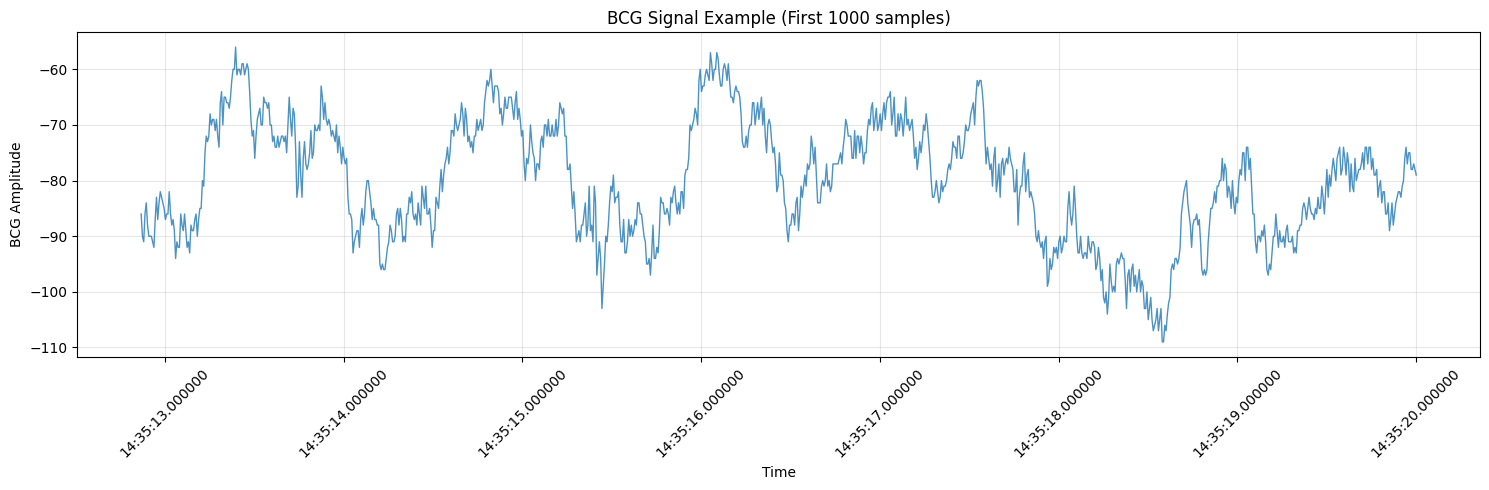

In [5]:
def plot_bcg_signal(data_dict, title="BCG Signal", samples_to_plot=1000):
    """Plot a segment of BCG data with proper timestamps"""
    plt.figure(figsize=(15, 5))

    # Extract the DataFrame from the dictionary
    df = data_dict['bcg_data']

    # Plot first n samples
    plot_df = df.head(samples_to_plot)

    plt.plot(plot_df['Datetime'], plot_df['BCG'],
             linewidth=1, alpha=0.8)

    # Format x-axis
    ax = plt.gca()
    ax.xaxis.set_major_formatter(DateFormatter('%H:%M:%S.%f'))
    plt.xticks(rotation=45)

    plt.title(f"{title} (First {samples_to_plot} samples)")
    plt.ylabel("BCG Amplitude")
    plt.xlabel("Time")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


# %%
# Plot first file as example
if all_bcg_data_with_ref:
    first_file_data = next(iter(all_bcg_data_with_ref.values()))
    print("BCG Data Columns:", first_file_data['bcg_data'].columns)
    # Now available
    print("RR Data Columns:", first_file_data['rr_data'].columns)
    plot_bcg_signal(first_file_data, title="BCG Signal Example",
                    samples_to_plot=1000)

## 4. Synchronize Data

In [6]:
def check_time_alignment(bcg_data, rr_data):
    """Verify if BCG and RR data overlap in time"""
    bcg_start = bcg_data['Datetime'].min()
    bcg_end = bcg_data['Datetime'].max()
    rr_start = rr_data['Datetime'].min()
    rr_end = rr_data['Datetime'].max()
    
    print(f"BCG Range: {bcg_start} to {bcg_end}")
    print(f"RR Range:  {rr_start} to {rr_end}")
    
    if rr_start > bcg_end or rr_end < bcg_start:
        print("Warning: No temporal overlap between BCG and RR data!")
        return False
    return True

In [7]:
def synchronize_data(bcg_data, rr_data):
    """Align BCG and RR data based on timestamps"""
    # Convert to pandas DateTimeIndex for both datasets
    bcg_times = pd.DatetimeIndex(bcg_data['Datetime'])
    rr_times = pd.DatetimeIndex(rr_data['Datetime'])
    
    # Find overlapping period
    start_time = max(bcg_times.min(), rr_times.min())
    end_time = min(bcg_times.max(), rr_times.max())
    
    # Filter both datasets to overlapping period
    bcg_sync = bcg_data[bcg_data['Datetime'].between(start_time, end_time)]
    rr_sync = rr_data[rr_data['Datetime'].between(start_time, end_time)]
    
    print("Synchronizing...")
    print(f"BCG time range: {bcg_times.min()} to {bcg_times.max()}")
    print(f"RR time range: {rr_times.min()} to {rr_times.max()}")
    print(f"Overlapping window: {start_time} to {end_time}")
   
    return {
        'bcg': bcg_sync,
        'rr': rr_sync,
        'start_time': start_time,
        'end_time': end_time
    }

In [8]:
# After loading data, for each subject:
for bcg_path, data in all_bcg_data_with_ref.items():
    bcg_df = data['bcg_data']
    rr_df = data['rr_data']

    print(f"\n📁 Processing file: {os.path.basename(bcg_path)}")
    print(f"   BCG start: {bcg_df['Datetime'].min()}, end: {bcg_df['Datetime'].max()}")
    print(f"   RR  start: {rr_df['Datetime'].min()}, end: {rr_df['Datetime'].max()}")

    # Check alignment first
    if not check_time_alignment(bcg_df, rr_df):
        print("   ❌ Skipped: No overlapping time range.")
        continue

    # Synchronize data
    synchronized = synchronize_data(bcg_df, rr_df)
    
    bcg_sync = synchronized['bcg']
    rr_sync = synchronized['rr']

    # Check if trimmed data is non-empty
    if bcg_sync.empty or rr_sync.empty:
        print("   ⚠️ Skipped: Synchronization resulted in empty data.")
        continue

    print(f"   ✅ Synchronized:")
    print(f"      New BCG range: {bcg_sync['Datetime'].min()} to {bcg_sync['Datetime'].max()}")
    print(f"      New RR  range: {rr_sync['Datetime'].min()} to {rr_sync['Datetime'].max()}")

    # Update the dictionary with synchronized data
    all_bcg_data_with_ref[bcg_path]['sync_data'] = synchronized



📁 Processing file: 01_20231104_BCG.csv
   BCG start: 2023-11-03 14:35:12.865999872, end: 2023-11-03 21:48:54.344571648
   RR  start: 2023-11-03 22:39:15, end: 2023-11-04 05:45:52
BCG Range: 2023-11-03 14:35:12.865999872 to 2023-11-03 21:48:54.344571648
RR Range:  2023-11-03 22:39:15 to 2023-11-04 05:45:52
   ❌ Skipped: No overlapping time range.

📁 Processing file: 01_20231105_BCG.csv
   BCG start: 2023-11-04 11:17:35.239000064, end: 2023-11-04 22:05:51.624714240
   RR  start: 2023-11-04 19:12:20, end: 2023-11-05 06:01:22
BCG Range: 2023-11-04 11:17:35.239000064 to 2023-11-04 22:05:51.624714240
RR Range:  2023-11-04 19:12:20 to 2023-11-05 06:01:22
Synchronizing...
BCG time range: 2023-11-04 11:17:35.239000064 to 2023-11-04 22:05:51.624714240
RR time range: 2023-11-04 19:12:20 to 2023-11-05 06:01:22
Overlapping window: 2023-11-04 19:12:20 to 2023-11-04 22:05:51.624714240
   ✅ Synchronized:
      New BCG range: 2023-11-04 19:12:20.003285760 to 2023-11-04 22:05:51.624714240
      New RR 

In [84]:
import pandas as pd
import os

def get_synchronized_data(all_data, filename_or_path):
    """
    Returns synchronized BCG and RR data for a given file if available.

    Parameters:
        all_data (dict): Main data dictionary with paths and sync info.
        filename_or_path (str): Filename or full path to identify the sample.

    Returns:
        tuple: (sync_bcg_df, sync_rr_df) or (None, None) if not found.
    """
    for path, data in all_data.items():
        if filename_or_path in path:
            if 'sync_data' in data:
                return data['sync_data']['bcg'].copy(), data['sync_data']['rr'].copy()
            else:
                print(f"⚠️ No synchronized data found for: {os.path.basename(path)}")
                return None, None
    print(f"❌ File not found in dataset: {filename_or_path}")
    return None, None

# 🔹 Choose the desired filename or path substring
selected_file = "01_20231105_BCG.csv"  # <-- Change this to the subject/sample you want

# 🔹 Retrieve synchronized data
sync_bcg, sync_rr = get_synchronized_data(all_bcg_data_with_ref, selected_file)

# 🔹 Process BCG if available
if sync_bcg is not None:
    print(f"\n📁 Using synchronized BCG from: {selected_file}")

    # Set datetime as index
    sync_bcg.set_index('Datetime', inplace=True)

    # Resample to 50 Hz (20 ms intervals)
    bcg_resampled = sync_bcg.resample('20ms').mean().interpolate(method='linear')

    # Reset index
    bcg_resampled.reset_index(inplace=True)

    # Display first 10 samples
    print("\n🟢 First 10 resampled BCG samples (50 Hz):")
    print(bcg_resampled.head(10))
else:
    print("⚠️ Unable to resample: No synchronized BCG data.")



📁 Using synchronized BCG from: 01_20231105_BCG.csv

🟢 First 10 resampled BCG samples (50 Hz):
                 Datetime         BCG     Timestamp  fs
0 2023-11-04 19:12:20.000  -75.333333  1.699125e+12 NaN
1 2023-11-04 19:12:20.020  -41.666667  1.699125e+12 NaN
2 2023-11-04 19:12:20.040 -372.500000  1.699125e+12 NaN
3 2023-11-04 19:12:20.060 -705.333333  1.699125e+12 NaN
4 2023-11-04 19:12:20.080 -298.666667  1.699125e+12 NaN
5 2023-11-04 19:12:20.100 -119.333333  1.699125e+12 NaN
6 2023-11-04 19:12:20.120  -45.333333  1.699125e+12 NaN
7 2023-11-04 19:12:20.140 -471.500000  1.699125e+12 NaN
8 2023-11-04 19:12:20.160 -458.333333  1.699125e+12 NaN
9 2023-11-04 19:12:20.180 -487.333333  1.699125e+12 NaN


In [85]:
bcg_resampled

,Datetime,BCG,Timestamp,fs
0,2023-11-04 19:12:20.000,-75.333333,1.699125e+12,NaN
1,2023-11-04 19:12:20.020,-41.666667,1.699125e+12,NaN
2,2023-11-04 19:12:20.040,-372.500000,1.699125e+12,NaN
3,2023-11-04 19:12:20.060,-705.333333,1.699125e+12,NaN
4,2023-11-04 19:12:20.080,-298.666667,1.699125e+12,NaN
...,...,...,...,...
520577,2023-11-04 22:05:51.540,-31.500000,1.699136e+12,NaN
520578,2023-11-04 22:05:51.560,-29.666667,1.699136e+12,NaN
520579,2023-11-04 22:05:51.580,-31.666667,1.699136e+12,NaN
520580,2023-11-04 22:05:51.600,-31.666667,1.699136e+12,NaN


In [86]:
# Regenerate Timestamp (in milliseconds)
bcg_resampled['Timestamp'] = bcg_resampled['Datetime'].astype('int64') // 10**6

# Set the new sampling frequency
bcg_resampled['fs'] = 50

# Preview again
print(bcg_resampled.head(10))


                 Datetime         BCG      Timestamp  fs
0 2023-11-04 19:12:20.000  -75.333333  1699125140000  50
1 2023-11-04 19:12:20.020  -41.666667  1699125140020  50
2 2023-11-04 19:12:20.040 -372.500000  1699125140040  50
3 2023-11-04 19:12:20.060 -705.333333  1699125140060  50
4 2023-11-04 19:12:20.080 -298.666667  1699125140080  50
5 2023-11-04 19:12:20.100 -119.333333  1699125140100  50
6 2023-11-04 19:12:20.120  -45.333333  1699125140120  50
7 2023-11-04 19:12:20.140 -471.500000  1699125140140  50
8 2023-11-04 19:12:20.160 -458.333333  1699125140160  50
9 2023-11-04 19:12:20.180 -487.333333  1699125140180  50


In [87]:
import math

# Save resampled BCG to CSV
resampled_path = "resampled_bcg_01_20231105.csv"
bcg_resampled['Timestamp'] = bcg_resampled['Datetime'].astype('int64') // 10**6  # Convert to ms
bcg_resampled['fs'] = 50  # Sampling frequency
bcg_resampled[['Timestamp', 'BCG']].to_csv(resampled_path, index=False)
print(f"✅ Saved resampled BCG to {resampled_path}")

✅ Saved resampled BCG to resampled_bcg_01_20231105.csv


In [88]:

# Load resampled data for analysis
df = pd.read_csv(resampled_path)
rawData = df[['Timestamp', 'BCG']].to_numpy()

In [89]:
# Prepare inputs
utc_time = bcg_resampled['Timestamp']  # milliseconds
utc_time = utc_time.to_numpy()
data_stream = bcg_resampled['BCG']
fs = 50
start_point, end_point, window_shift = 0, 500, 500

results_dir = r"C:\Users\tony_\OneDrive\Desktop\data analytics\results"
os.makedirs(results_dir, exist_ok=True)

# ==========================================================================================================
# Pattern detection (e.g. motion artifact removal)
data_stream, utc_time = detect_patterns(start_point, end_point, window_shift, data_stream, utc_time, plot=1)

# ==========================================================================================================
# BCG signal extraction
movement = band_pass_filtering(data_stream, fs, "bcg")

# ==========================================================================================================
# Respiratory signal extraction
breathing = band_pass_filtering(data_stream, fs, "breath")
breathing = remove_nonLinear_trend(breathing, 3)
breathing = savgol_filter(breathing, 11, 3)

# ==========================================================================================================
# Wavelet decomposition for cardiac cycle extraction
w = modwt(movement, 'bior3.9', 4)
dc = modwtmra(w, 'bior3.9')
wavelet_cycle = dc[4]

# ==========================================================================================================
# Vital signs estimation (e.g., Heart Rate)
t1, t2, window_length, window_shift = 0, 500, 500, 500
hop_size = math.floor((window_length - 1) / 2)
limit = int(math.floor(breathing.size / window_shift))

# Heart Rate estimation from wavelet_cycle
beats = vitals(t1, t2, window_shift, limit, wavelet_cycle, utc_time, mpd=1, plot=0)

In [93]:
import pandas as pd

# If datetime is not in columns but is already the index, reset and convert
if 'Timestamp' not in sync_rr.columns:
    sync_rr = sync_rr.reset_index()

# Now ensure it's in datetime format
sync_rr['Timestamp'] = pd.to_datetime(sync_rr['Timestamp'])

# Set datetime as index
sync_rr = sync_rr.set_index('Timestamp')

# Keep only numeric columns (like Heart Rate and RR Interval)
numeric_cols = sync_rr.select_dtypes(include='number')

# Resample every 10 seconds and compute mean
hr_df_avg_10s = numeric_cols.resample('10S').mean().reset_index()

In [94]:
print(hr_df_avg_10s)

               Timestamp          HR  RR_Interval
0    2023-11-04 19:12:20   98.687500     0.639625
1    2023-11-04 19:12:30  100.625000     0.615062
2    2023-11-04 19:12:40   94.066667     0.644600
3    2023-11-04 19:12:50   92.625000     0.648687
4    2023-11-04 19:13:00   92.000000     0.803583
...                  ...         ...          ...
1037 2023-11-04 22:05:10   59.300000     1.002800
1038 2023-11-04 22:05:20   60.300000     0.993200
1039 2023-11-04 22:05:30   60.100000     1.011600
1040 2023-11-04 22:05:40   59.800000     1.029900
1041 2023-11-04 22:05:50   59.500000     0.968500

[1042 rows x 3 columns]


In [92]:
len(beats)

1041

In [43]:
import pandas as pd

reference_df = pd.read_csv(
    r"C:\Users\tony_\OneDrive\Desktop\data analytics\project\dataset\dataset\data\01\Reference\RR\01_20231104_RR.csv"
)

print("First few rows of the raw reference file:")
print(reference_df.head())

print("\nTimestamp dtype before conversion:")
print(reference_df['Timestamp'].dtype)

print("\nMax timestamp value:", reference_df['Timestamp'].max())


First few rows of the raw reference file:
            Timestamp  Heart Rate  RR Interval in seconds
0  2023/11/3 22:39:15          85                   0.708
1  2023/11/3 22:39:15          85                   0.657
2  2023/11/3 22:39:16          85                   0.798
3  2023/11/3 22:39:17          84                   0.712
4  2023/11/3 22:39:17          84                   0.730

Timestamp dtype before conversion:
object

Max timestamp value: 2023/11/4 5:45:52


In [99]:
# Ensure both arrays have the same length
min_length = min(len(beats), len(hr_df_avg_10s))

# Trim the larger one
beats_trimmed = beats[:min_length]
hr_df_avg_10s_trimmed = hr_df_avg_10s[:min_length]

len(hr_df_avg_10s_trimmed)
#len(beats)

1041

In [100]:
hr_df_avg_10s_trimmed

,Timestamp,HR,RR_Interval
0,2023-11-04 19:12:20,98.687500,0.639625
1,2023-11-04 19:12:30,100.625000,0.615062
2,2023-11-04 19:12:40,94.066667,0.644600
3,2023-11-04 19:12:50,92.625000,0.648687
4,2023-11-04 19:13:00,92.000000,0.803583
...,...,...,...
1036,2023-11-04 22:05:00,59.300000,0.999800
1037,2023-11-04 22:05:10,59.300000,1.002800
1038,2023-11-04 22:05:20,60.300000,0.993200
1039,2023-11-04 22:05:30,60.100000,1.011600


In [101]:
HR=hr_df_avg_10s_trimmed['HR'].tolist()

In [104]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Ensure both are NumPy arrays
beats_trimmed = np.array(beats_trimmed)
HR = np.array(HR)

# Ensure they are of the same length
min_length = min(len(beats_trimmed), len(HR))
beats_trimmed = beats_trimmed[:min_length]
HR = HR[:min_length]

# Drop NaN values and exclude zeros in HR
valid_indices = ~np.isnan(beats_trimmed) & ~np.isnan(HR) & (HR != 0)
beats_trimmed = beats_trimmed[valid_indices]
HR = HR[valid_indices]

# Calculate metrics
mae = mean_absolute_error(HR, beats_trimmed)
rmse = np.sqrt(mean_squared_error(HR, beats_trimmed))
mape = np.mean(np.abs((HR - beats_trimmed) / HR)) * 100

# Print the results
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Square Error (RMSE): {rmse}')
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')


Mean Absolute Error (MAE): 8.717414897879049
Root Mean Square Error (RMSE): 10.784610246050743
Mean Absolute Percentage Error (MAPE): 11.54%
